In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from vit import *

In [14]:
# Setup: folders and models
# model_folder = "/usr/itetnas04/data-scratch-01/ddordevic/data/cluster_scripts/vit_copy/model_save/"
model_folder =  "C:/Users/danil/Desktop/Master thesis/Code/msc-thesis/model_save/"
model_file = "vit_model_0404.pt"
model_path = model_folder + model_file

# database_folder = "/usr/itetnas04/data-scratch-01/ddordevic/data/cluster_scripts/vit_copy/extracted_features/"
database_folder = "C:/Users/danil/Desktop/Master thesis/Code/msc-thesis/extracted_features/"
database_file = "training_mnist.pkl" # or "test_mnist.pkl"
database_path = database_folder + database_file

unflatten_shape = (28,28) # MNIST image shape used for deflattening
K = 3 # return K best matching images

In [15]:
# Load the database into a pandas DataFrame
# DataFrame contains the following columns: ['image','feature','label']
# The 1st columns contains a flattened image

database_df = pd.read_pickle(database_path)

In [59]:
# Get database length
num_images = len(database_df)

In [62]:
# Fetch the database matrix
database_matrix = []
for i in range(num_images):
    database_matrix.append(database_df.iloc[i]['feature'])
database_matrix = torch.stack(database_matrix)

In [77]:
# Extract a random query image from the database
query_img_idx = np.random.randint(0, num_images)
query_img = database_df.iloc[query_img_idx]['image']#.unflatten(0, unflatten_shape)
query_ftrs = database_df.iloc[query_img_idx]['feature']
query_label = database_df.iloc[query_img_idx]['label']

# Multiply the database matrix and the query feature vector
match_scores = database_matrix @ query_ftrs
sorted_scores, sorted_ind = torch.sort(match_scores, descending=True)

# Take K best matches
k_best_ind = sorted_ind[0:K]

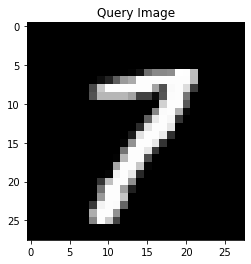

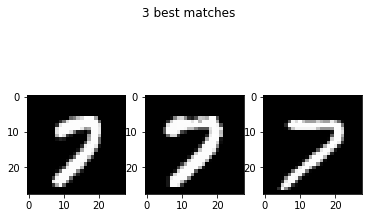

In [78]:
# Visualize the K best images
# Print the query image:
plt.imshow(query_img[0], cmap='gray')
plt.title('Query Image')

# Print the best matching images (according to inner product, as suggested in the paper I found)
fig, axs = plt.subplots(1, K)
fig.suptitle(f'{K} best matches')

for i, best_idx in enumerate(k_best_ind.numpy()):
    axs[i].imshow(database_df.iloc[best_idx]['image'][0], cmap='gray')